# A/B Test Analysis 
### _Free Trial Screening Initiative_

**`Team 8:`**
`Joseph Miguel, Jeremy Grace, Jonathan Hilgart, & Victor Vulovic`

---

## Environment setup

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
import statsmodels.api as smf

from math import sqrt
from scipy.stats import binom_test
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Users/Jeremy/anaconda/envs/gu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Baseline

In [6]:
col_names = ['Text','Numbers']
baseline_df = pd.read_csv('data/baseline.csv',names=col_names)

In [7]:
baseline_df.T

,0,1,2,3,4,5,6
Text,Unique cookies to view page per day:,"Unique cookies to click ""Start free trial"" per...",Enrollments per day:,"Click-through-probability on ""Start free trial"":","Probability of enrolling, given click:","Probability of payment, given enroll:","Probability of payment, given click"
Numbers,40000,3200,660,0.08,0.20625,0.53,0.109313


## $$Sample\ Size\ Calculation$$

## Net Conversion Rate sample size (n is per group)
In Python
`# Pageviews sample size for improving net conversion benchmark
es = sms.proportion_effectsize(0.109313, 0.109313+0.0075)
sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)`

- Usign an R Function

`power.prop.test(p1 = .109313, p2 = .109313 + .0075, power = .8)`

output:

    Two-sample comparison of proportions power calculation 

              n = 27984.02
             p1 = 0.109313
             p2 = 0.116813
      sig.level = 0.05
          power = 0.8
    alternative = two.sided



##  Enrollment sample size for improving retention benchmark for Retention
In Python
`es = sms.proportion_effectsize(0.53, 0.53+0.01)
sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)`

- Retention using R function

`power.prop.test(p1 = .53, p2 = .53 + .01, power = .8)`

output:

    Two-sample comparison of proportions power calculation 

              n = 39050.92
             p1 = 0.53
             p2 = 0.54
      sig.level = 0.05
          power = 0.8
    alternative = two.sided


    
## Gross conversion rate $n$ is per goup

##  Enrollment sample size for improving retention benchmark for Retention
In Python
`es = sms.proportion_effectsize( .20625, .20625 + .01)
sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)`

- In R

`power.prop.test(p1 = .20625, p2 = .20625 + .01, power = .8)`

output:

    Two-sample comparison of proportions power calculation 

              n = 26154.97
             p1 = 0.20625
             p2 = 0.21625
      sig.level = 0.05
          power = 0.8
    alternative = two.sided


    
## Click-Through-Probability (CTP) $n$ is per group
In Python
`es = sms.proportion_effectsize( .08, .08 + .01)
sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)`
- In R

`power.prop.test(p1 = .08, p2 = .08 + .01, power = .8)`

output:

    Two-sample comparison of proportions power calculation 

              n = 12207.75
             p1 = 0.08
             p2 = 0.09
      sig.level = 0.05
          power = 0.8
    alternative = two.sided




    
### Total site traffic

- Net Converion rate : need $28$k clicks for each group
- Gross Conversion rate: need $26$k clicks for each group
- Retention rate: need $40$k enrollments for each group

> We propose to run this test by diverting $50$% of the traffic which will be split into $25$% going to the control page and $25$% going to the test page. Based off of the baseline number of clicks per day ($3,200$), this means there will be $1,600$ clicks or $800$ clicks per group per day. Therefore, we will need to run this test for **36 days** to collect enough information for both groups.

> The key metric will be net conversion rate; however, we will also look at retention rate since it is the metric most influenced by this test.


### Duration and exposure

- We will to run this test for 36 days in order to hit our proposed sample size.
- There is relatively low risk to run this test because Udacity has already identified that there is a correlation between students who do not have enough time for the course and revenue. 

---

# Key metrics: _Retention rate_ and _Net conversion rate_

### `Control` Exploration

In [8]:
#Control data
control_df = pd.read_csv('data/control.csv')
control_df['CTP']=control_df.Clicks/control_df.Pageviews
control_df['Gross_Conversion']=control_df.Enrollments/control_df.Clicks
control_df['Retention']=control_df.Payments / control_df.Enrollments
control_df['Net_Conversion']=  control_df.Payments / control_df.Clicks
control_df['CTP']=control_df.Clicks/control_df.Pageviews

In [9]:
control_df

,Date,Pageviews,Clicks,Enrollments,Payments,CTP,Gross_Conversion,Retention,Net_Conversion
0,"Sat, Oct 11",7723,687,134.0,70.0,0.088955,0.195051,0.522388,0.101892
1,"Sun, Oct 12",9102,779,147.0,70.0,0.085586,0.188703,0.476190,0.089859
2,"Mon, Oct 13",10511,909,167.0,95.0,0.086481,0.183718,0.568862,0.104510
3,"Tue, Oct 14",9871,836,156.0,105.0,0.084693,0.186603,0.673077,0.125598
4,"Wed, Oct 15",10014,837,163.0,64.0,0.083583,0.194743,0.392638,0.076464
5,"Thu, Oct 16",9670,823,138.0,82.0,0.085109,0.167679,0.594203,0.099635
6,"Fri, Oct 17",9008,748,146.0,76.0,0.083037,0.195187,0.520548,0.101604
7,"Sat, Oct 18",7434,632,110.0,70.0,0.085015,0.174051,0.636364,0.110759
8,"Sun, Oct 19",8459,691,131.0,60.0,0.081688,0.189580,0.458015,0.086831
9,"Mon, Oct 20",10667,861,165.0,97.0,0.080716,0.191638,0.587879,0.112660


In [10]:
control_df_truncated = control_df.iloc[:23,:]

In [11]:
print('Total clicks for the control group is {}'.format(np.sum(control_df.Clicks)))

Total clicks for the control group is 28378


### `Experiment` Exploration

In [13]:
#Experiment Data
experiment_df = pd.read_csv('data/experiment.csv')
experiment_df['CTP']=experiment_df.Clicks/experiment_df.Pageviews
experiment_df['Gross_Conversion']=experiment_df.Enrollments/experiment_df.Clicks
experiment_df['Retention']=experiment_df.Payments / experiment_df.Enrollments
experiment_df['Net_Conversion']=  experiment_df.Payments / experiment_df.Clicks
experiment_df_truncated = experiment_df.iloc[:23,:]

In [14]:
experiment_df_truncated

,Date,Pageviews,Clicks,Enrollments,Payments,CTP,Gross_Conversion,Retention,Net_Conversion
0,"Sat, Oct 11",7716,686,105.0,34.0,0.088906,0.153061,0.323810,0.049563
1,"Sun, Oct 12",9288,785,116.0,91.0,0.084518,0.147771,0.784483,0.115924
2,"Mon, Oct 13",10480,884,145.0,79.0,0.084351,0.164027,0.544828,0.089367
3,"Tue, Oct 14",9867,827,138.0,92.0,0.083815,0.166868,0.666667,0.111245
4,"Wed, Oct 15",9793,832,140.0,94.0,0.084959,0.168269,0.671429,0.112981
5,"Thu, Oct 16",9500,788,129.0,61.0,0.082947,0.163706,0.472868,0.077411
6,"Fri, Oct 17",9088,780,127.0,44.0,0.085827,0.162821,0.346457,0.056410
7,"Sat, Oct 18",7664,652,94.0,62.0,0.085073,0.144172,0.659574,0.095092
8,"Sun, Oct 19",8434,697,120.0,77.0,0.082642,0.172166,0.641667,0.110473
9,"Mon, Oct 20",10496,860,153.0,98.0,0.081936,0.177907,0.640523,0.113953


---
## Signs

In [15]:
## new df
signs_df = pd.DataFrame(control_df_truncated.Date)

# Net Conversion Rates

signs_df['Control_Net_Conversion'] = control_df_truncated.Net_Conversion
signs_df['Experiment_Net_Conversion'] = experiment_df_truncated.Net_Conversion

#Retention Rates

signs_df['Control_Retention'] = control_df_truncated.Retention
signs_df['Experiment_Retention'] = experiment_df_truncated.Retention


# Success for signs is when the difference is greater than dmin
signs_df['Net_Conversion_Sign'] =   signs_df['Experiment_Net_Conversion']-signs_df['Control_Net_Conversion'] > .0075
signs_df['Retention'] = (signs_df['Experiment_Retention']-signs_df['Control_Retention']) > .01

In [16]:
signs_df

,Date,Control_Net_Conversion,Experiment_Net_Conversion,Control_Retention,Experiment_Retention,Net_Conversion_Sign,Retention
0,"Sat, Oct 11",0.101892,0.049563,0.522388,0.323810,False,False
1,"Sun, Oct 12",0.089859,0.115924,0.476190,0.784483,True,True
2,"Mon, Oct 13",0.104510,0.089367,0.568862,0.544828,False,False
3,"Tue, Oct 14",0.125598,0.111245,0.673077,0.666667,False,False
4,"Wed, Oct 15",0.076464,0.112981,0.392638,0.671429,True,True
5,"Thu, Oct 16",0.099635,0.077411,0.594203,0.472868,False,False
6,"Fri, Oct 17",0.101604,0.056410,0.520548,0.346457,False,False
7,"Sat, Oct 18",0.110759,0.095092,0.636364,0.659574,False,True
8,"Sun, Oct 19",0.086831,0.110473,0.458015,0.641667,True,True
9,"Mon, Oct 20",0.112660,0.113953,0.587879,0.640523,False,True


In [17]:
signs_df.Net_Conversion_Sign.sum()

8

In [18]:
len(signs_df.Date)

23

- Eight instance of **Net conversion rate** being greater than dmin.


In [20]:
print('The p-value of Net conversion rate being greater than dmin (.0075) is {:.2%}'.format(binom_test(8,23)))

The p-value of Net conversion rate being greater than dmin (.0075) is 21.00%


- This means that there is $\underline{not\ a\ statistically\ significant\ difference}$ in **Net conversion rates** between the control and experiment group. 
    - we want the p-value to be less than .05


In [23]:
signs_df.Retention.sum()

13

In [24]:
len(signs_df.Date)

23

- 13 instances of Retention being greater in the experiment group,

In [25]:
print('The p-value of Retenteion rate being greater than dmin (.01) is {:.2%}'.format(binom_test(13,23)))

The p-value of Retenteion rate being greater than dmin (.01) is 67.76%


- The test on Retention is also _inconclusive_ for this sign test.

---
# Frequentist test 
### Retention rate between the two groups using a $95$% confidence interval

* First hypothesis, test Retention rates using Pooled Standard Error

In [26]:
control_retention= np.mean(control_df_truncated.Retention)
control_number_of_enrollments = int(np.sum(control_df_truncated.Enrollments))
control_number_of_payments = int(np.sum(control_df_truncated.Payments))

experiment_retention = np.mean(experiment_df_truncated.Retention)
experiment_number_of_enrollments = int(np.sum(experiment_df_truncated.Enrollments))
experiment_number_of_payments = int(np.sum(experiment_df_truncated.Payments))


* Next, test the differences in Net conversion rates

In [29]:
control_net_conversion= np.mean(control_df_truncated.Net_Conversion)
control_number_of_clicks = int(np.sum(control_df_truncated.Clicks))
control_number_of_payments = int(np.sum(control_df_truncated.Payments))

experiment_retention = np.mean(experiment_df_truncated.Net_Conversion)
experiment_number_of_clicks= int(np.sum(experiment_df_truncated.Clicks))
experiment_number_of_payments = int(np.sum(experiment_df_truncated.Payments))


* Look at differences in CTPs for all days

In [30]:
control_ctp = np.mean(control_df.CTP)
control_number_of_clicks = int(np.sum(control_df.Clicks))
control_number_of_pageviews= int(np.sum(control_df.Pageviews))

experiment_ctp = np.mean(experiment_df.CTP)
experiment_number_of_clicks= int(np.sum(experiment_df.Clicks))
experiment_number_of_pageviews = int(np.sum(experiment_df.Pageviews))


In [36]:
def two_sample_pooled_se(control_total_num, control_num_of_success, experiment_total_num, experiment_num_of_success, confidence_z=1.96):
    """Return the confidence interval for the difference 
    in two sample proportions at 95% confidence level"""
    control_proportion = control_num_of_success/control_total_num
    experiment_proportion = experiment_num_of_success/experiment_total_num
    proportion_difference = experiment_proportion - control_proportion
    
    pooled_propotion = (experiment_num_of_success  + control_num_of_success) / \
    (experiment_total_num+control_total_num)
    
    pooled_standard_error = sqrt(pooled_propotion*(1-pooled_propotion)*\
                            (1/experiment_total_num + 1/control_total_num))
    
    return('The {} z-score confidence interval is: {:.2%} to {:.2%}'.format(confidence_z,
          proportion_difference-confidence_z*pooled_standard_error,proportion_difference+confidence_z*pooled_standard_error))
 

* Confidence Internval for Retention between control and experiment

In [38]:
retention_pse = two_sample_pooled_se(control_number_of_enrollments,control_number_of_payments,
                     experiment_number_of_enrollments,experiment_number_of_payments )

print(retention_pse)

The 1.96 z-score confidence interval is: 0.81% to 5.41%


<br>
* Confidence Interval for Net conversion rate between control and experiment

In [40]:
netconv_pse = two_sample_pooled_se(control_number_of_clicks,control_number_of_payments,
                    experiment_number_of_clicks,experiment_number_of_payments)

print(netconv_pse)

The 1.96 z-score confidence interval is: -0.72% to 0.12%


---
## Sanity Checks
> It should be noted that we do not have enough data to determine the statistical significance for retention rates. 
- Ensure that our invariant metrics do not vary across the groups.

<br>

$H_o$ = The difference between control and experiment CTP is less than or equal to dmin

$H_1$ = The difference between control and experiment for CTP is greater than dmin

* Confidence Interval for CTP between control and experiment

In [41]:
ctp_pse = two_sample_pooled_se(control_number_of_pageviews,control_number_of_clicks,
                    experiment_number_of_pageviews,experiment_number_of_clicks)

print(ctp_pse)

The 1.96 z-score confidence interval is: -0.12% to 0.14%


> The 95% confidence interval for CTP between the control and experiment group is not statistically significant. This means that our invariant metric holds between both groups.

### Pageviews

* The pageviews is also an invariant metric between groups. 
    - We want to ensure that both tests are receiving the same amount of traffic.

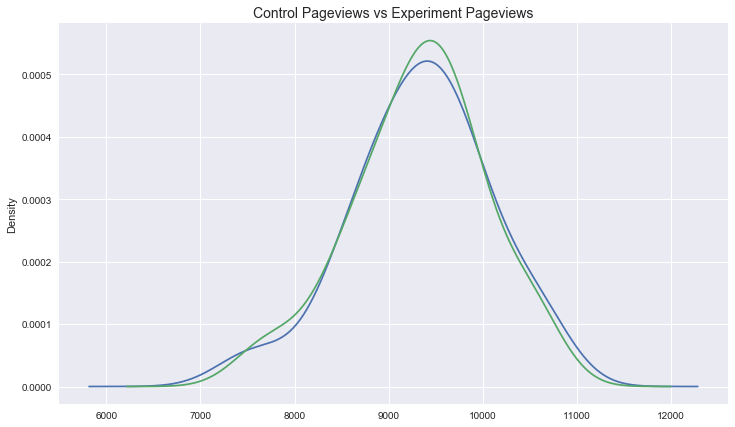

In [47]:
plt.figure(figsize=(12,7))
control_df.Pageviews.plot(kind='kde')
experiment_df.Pageviews.plot(kind='kde')
plt.title('Control Pageviews vs Experiment Pageviews', fontsize=14);


> Here, we can see $\underline{roughly\ the\ same}$ number of pageviews between the two groups.

---
# Bayesian analysis

In [48]:
with pm.Model() as retention: # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    control_prior = pm.Beta('control_retention', alpha=1 + control_number_of_payments,
                            beta=1+control_number_of_enrollments - control_number_of_payments ) # uniform prior
    experiment_prior = pm.Beta('experiment_retention', alpha=1 + experiment_number_of_payments, 
                               beta=1+experiment_number_of_enrollments - experiment_number_of_payments) # uniform prior
    
    
    # Inference
    start = pm.find_MAP()  # Find good starting point
    step = pm.Slice()  # Instantiate MCMC sampling algorithm
    trace = pm.sample(10000, step, start=start, progressbar=False)  # draw posterior samples using slice sampling
    

Optimization terminated successfully.
         Current function value: -4.953189
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [49]:
trace.varnames

['control_retention_logodds_',
 'experiment_retention_logodds_',
 'control_retention',
 'experiment_retention']

/Users/Jeremy/anaconda/envs/gu/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


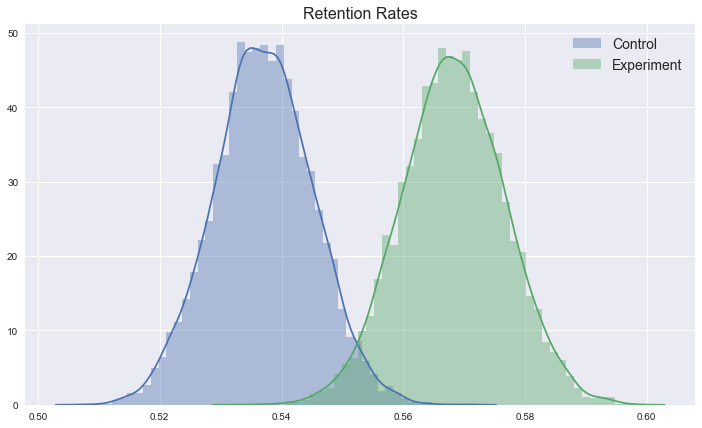

In [53]:
plt.figure(figsize=(12,7))
sns.distplot(trace['control_retention'],label='Control')
sns.distplot(trace['experiment_retention'],label='Experiment')
plt.title('Retention Rates', fontsize=16)
plt.legend(fontsize=14);


In [54]:
print('We are {:.2%} confident that our experiment improved Retention'.format(
        np.mean(trace['control_retention']<trace['experiment_retention'])))

We are 99.49% confident that our experiment improved retention


<br>

In [55]:
print('We are {:.2%} confident that our experiment improved Retention by over 1%'.format(
        np.mean((trace['control_retention']+.01)<trace['experiment_retention'])))

We are 96.47% confident that our experiment improved Retention by over 1%


<br>

* Next check the Net conversion rate

In [58]:
with pm.Model() as conversion_rate:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    control_prior = pm.Beta('control_net-conversion', alpha=1 + control_number_of_payments,
                            beta=1+control_number_of_clicks - control_number_of_payments )  # uniform prior
    
    experiment_prior = pm.Beta('experiment_net-conversion', alpha=1 + experiment_number_of_payments, 
                               beta=1+experiment_number_of_clicks- experiment_number_of_payments)  # uniform prior
    
    # Inference
    start = pm.find_MAP()  # Find good starting point
    step = pm.Slice()  # Instantiate MCMC sampling algorithm
    trace_cr = pm.sample(100000, step, start=start, progressbar=False)  # draw posterior samples using slice sampling 


Optimization terminated successfully.
         Current function value: -5.684873
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


/Users/Jeremy/anaconda/envs/gu/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


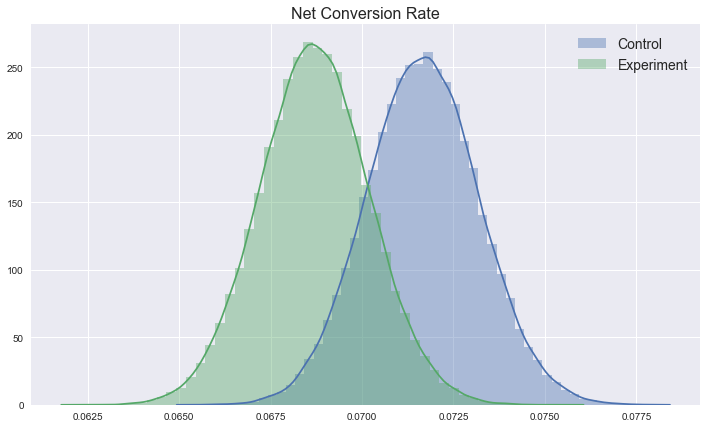

In [59]:
plt.figure(figsize=(12,7))
sns.distplot(trace_cr['control_net-conversion'],label='Control')
sns.distplot(trace_cr['experiment_net-conversion'],label='Experiment')
plt.title('Net Conversion Rate', fontsize=16)
plt.legend(fontsize=14);

In [62]:
print('We are {:.2%} confident that our experiment improved Net conversion rate'.format(

np.mean(trace_cr['control_net-conversion']<trace_cr['experiment_net-conversion'])))

We are 8.43% confident that our experiment improved Net conversion rate


<br>

In [63]:
print('We are {:.2%} confident that our experiment improved Net conversion rate above 1%'.format(

np.mean(trace_cr['control_net-conversion']+.01<trace_cr['experiment_net-conversion'])))

We are 0.00% confident that our experiment improved Net conversion rate above 1%


<br>

In [64]:
print('We are {:.2%} confident that our control was better than our experiment for  Net conversion rate'.format(

np.mean(trace_cr['control_net-conversion']>trace_cr['experiment_net-conversion'])))

We are 91.57% confident that our control was better than our experiment for  Net conversion rate


---

## Machine learning to predict the number of payments

### Use Random Forest Regression to oversample from trainig data and hopefully reduce variance


### `Control group` 

In [65]:
control_df[23:]

,Date,Pageviews,Clicks,Enrollments,Payments,CTP,Gross_Conversion,Retention,Net_Conversion
23,"Mon, Nov 3",9437,788,NaN,NaN,0.083501,NaN,NaN,NaN
24,"Tue, Nov 4",9420,781,NaN,NaN,0.082909,NaN,NaN,NaN
25,"Wed, Nov 5",9570,805,NaN,NaN,0.084117,NaN,NaN,NaN
26,"Thu, Nov 6",9921,830,NaN,NaN,0.083661,NaN,NaN,NaN
27,"Fri, Nov 7",9424,781,NaN,NaN,0.082874,NaN,NaN,NaN
28,"Sat, Nov 8",9010,756,NaN,NaN,0.083907,NaN,NaN,NaN
29,"Sun, Nov 9",9656,825,NaN,NaN,0.085439,NaN,NaN,NaN
30,"Mon, Nov 10",10419,874,NaN,NaN,0.083885,NaN,NaN,NaN
31,"Tue, Nov 11",9880,830,NaN,NaN,0.084008,NaN,NaN,NaN
32,"Wed, Nov 12",10134,801,NaN,NaN,0.079041,NaN,NaN,NaN


In [66]:
control_X_train = np.array([control_df_truncated.Pageviews,control_df_truncated.Clicks]).reshape(-1,2)
control_y_train = np.array(control_df_truncated.Payments)

X_control_train, X_control_test, y_control_train, y_control_test =\
    train_test_split(control_X_train, control_y_train, test_size=0.2, random_state=0)
    
control_X_test = np.array([control_df.Pageviews[:23],control_df.Clicks[:23]]).reshape(-1,2)


In [67]:
control_rf = RandomForestRegressor(n_estimators=100)

In [68]:
control_rf.fit(X_control_train,y_control_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### RMSE on `Control`

In [69]:
rmse_control = np.linalg.norm(y_control_test- control_rf.predict(X_control_test))/sqrt(len(y_control_test))


In [70]:
rmse_control

25.557131685695875

In [71]:
control_rf_test = RandomForestRegressor(n_estimators=100)
control_rf_test.fit(control_X_train,control_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

<br>

#### Predicted values for the `control` payments per day assume $\$400$ is the price of a payment

In [78]:
control_predictions = control_rf_test.predict(control_X_test)
control_predictions_money = control_predictions*400
predicted_totalpayment_control = np.sum([i*400 for i in control_rf_test.predict(control_X_test)])
predicted_totalpayment_control


817468.0

###  `Experiment` group

In [72]:
experiment_X_train = np.array([experiment_df_truncated.Pageviews,experiment_df_truncated.Clicks]).reshape(-1,2)
experiment_y_train = np.array(experiment_df_truncated.Payments)

X_experiment_train, X_experiment_test, y_experiment_train, y_experiment_test =\
    train_test_split(experiment_X_train, experiment_y_train, test_size=0.2, random_state=0)
    
experiment_X_test = np.array([experiment_df.Pageviews[:23],experiment_df.Clicks[:23]]).reshape(-1,2)


In [73]:
experiment_rf = RandomForestRegressor(n_estimators=1000)
experiment_rf.fit(X_experiment_train,y_experiment_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

<br>

### RMSE on `Experiment`

In [74]:
rmse_experiment = np.linalg.norm(y_experiment_test- experiment_rf.predict(X_experiment_test))/ \
sqrt(len(y_experiment_test))
rmse_experiment


19.865752953261044

In [75]:
experiment_rf_test = RandomForestRegressor(n_estimators=100)
experiment_rf_test.fit(experiment_X_train,experiment_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

<br>

#### Predicted values for the `experiment` payments per day ssume $\$400$ is the price of a payment

In [76]:
predicted_paymenttotal_experiment = np.sum([i*400 for i in experiment_rf_test.predict(experiment_X_test)])
experiment_predictions= experiment_rf_test.predict(experiment_X_test)
experiment_prediction_money = experiment_predictions*400
predicted_paymenttotal_experiment


784292.0

/Users/Jeremy/anaconda/envs/gu/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


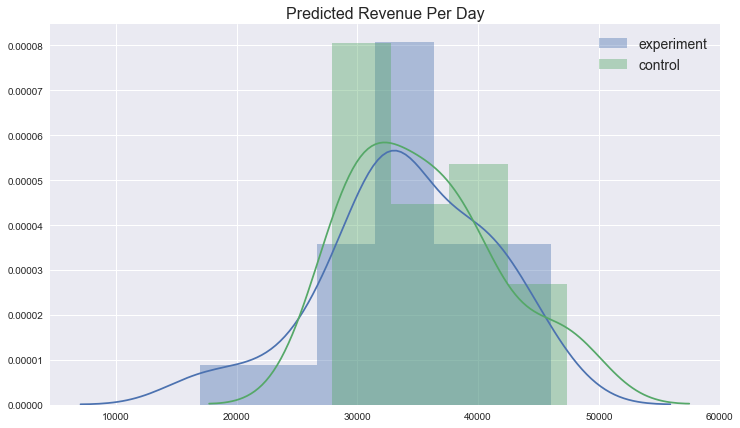

In [79]:
plt.figure(figsize=(12,7))
sns.distplot(experiment_prediction_money, label='experiment')
sns.distplot(control_predictions_money, label='control')
plt.legend(fontsize=14)
plt.title('Predicted Revenue Per Day', fontsize=16);

## Recommendation
- After reviewing the evidence, we suggest gradually increasing traffic to receive the squeeze page. This is due to the positive evidence from the bayesian analysis as well as the low business risk. 
- In addition, we suggest continuing to monitor the results and generate another report once the sample size requirement for frequentist statistics has been met. 
- Finally, additional metrics, such as revenue, can be used to further validate the total value of screening out people who may not complete a given course.